In [50]:
# some necessary imports
import os
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import GridSearchCV, cross_val_score
import seaborn as sns
from matplotlib import pyplot as plt
sns.set()
%matplotlib inline
plt.rcParams['figure.figsize'] = (15, 10)

In [51]:
!ls ../input

test-balanced.csv  test-unbalanced.csv	train-balanced-sarcasm.csv


In [52]:
train_df = pd.read_csv('../input/train-balanced-sarcasm.csv')

In [53]:
train_df.head()

,label,comment,author,subreddit,score,ups,downs,date,created_utc,parent_comment
0,0,NC and NH.,Trumpbart,politics,2,-1,-1,2016-10,2016-10-16 23:55:23,"Yeah, I get that argument. At this point, I'd ..."
1,0,You do know west teams play against west teams...,Shbshb906,nba,-4,-1,-1,2016-11,2016-11-01 00:24:10,The blazers and Mavericks (The wests 5 and 6 s...
2,0,"They were underdogs earlier today, but since G...",Creepeth,nfl,3,3,0,2016-09,2016-09-22 21:45:37,They're favored to win.
3,0,"This meme isn't funny none of the ""new york ni...",icebrotha,BlackPeopleTwitter,-8,-1,-1,2016-10,2016-10-18 21:03:47,deadass don't kill my buzz
4,0,I could use one of those tools.,cush2push,MaddenUltimateTeam,6,-1,-1,2016-12,2016-12-30 17:00:13,Yep can confirm I saw the tool they use for th...


In [54]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1010826 entries, 0 to 1010825
Data columns (total 10 columns):
label             1010826 non-null int64
comment           1010773 non-null object
author            1010826 non-null object
subreddit         1010826 non-null object
score             1010826 non-null int64
ups               1010826 non-null int64
downs             1010826 non-null int64
date              1010826 non-null object
created_utc       1010826 non-null object
parent_comment    1010826 non-null object
dtypes: int64(4), object(6)
memory usage: 77.1+ MB


In [55]:
train_df.dropna(subset=['comment'], inplace=True)

In [8]:
train_df.label.value_counts()

0    505405
1    505368
Name: label, dtype: int64

In [9]:
train_comments, valid_comments, y_train, y_valid = \
train_test_split(train_df['comment'], train_df['label'], random_state=17)

## First, let's make an exploratory data analysis to detect some important features

In [10]:
subreddits_to_plot = train_df.subreddit.value_counts().head(30).index

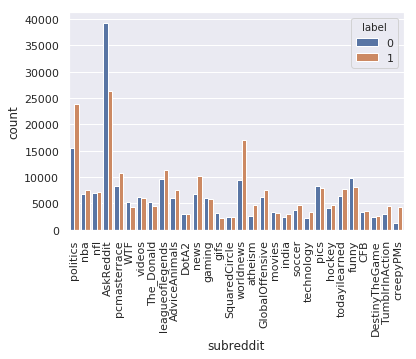

In [11]:
plot = sns.countplot(x='subreddit', data=train_df[train_df.subreddit.isin(subreddits_to_plot)], hue='label')
_ = plot.set_xticklabels(plot.get_xticklabels(), rotation=90)

**We can clearly see, that the percentage of sarcastic comments differs from subreddit to subreddit**

In [12]:
time_label_data = train_df.groupby(['date']).label.value_counts(normalize=True)

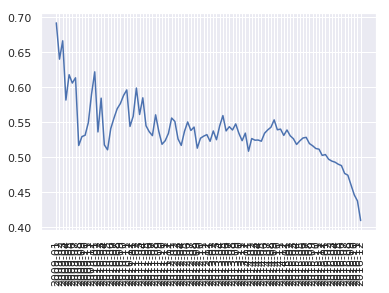

In [13]:
plot = sns.lineplot(data=time_label_data.loc[:, 1])
for item in plot.get_xticklabels():
    item.set_rotation(90)

**The general trend is that the amount of sarcasm in trands is decreasing**  
### Let's try to check if it's seasonal data

In [14]:
# get new features from existing
train_df['year'] = train_df.date.apply(lambda x: x.split('-')[0])
train_df['month'] = train_df.date.apply(lambda x: x.split('-')[1])

In [15]:
seasonal_time_year = train_df.groupby(['year', 'month']).label.value_counts(normalize=True).loc[:,:,1]\
.reset_index(level=[0, 1])
seasonal_time_year.month = seasonal_time_year.month.astype(int)
seasonal_time_year.head()

,year,month,label
0,2009,1,0.692308
1,2009,2,0.640449
2,2009,3,0.666667
3,2009,4,0.581967
4,2009,5,0.618182


**Create 4 new seasonal features: autumn, winter, spring and summer**

In [16]:
seasonal_time_year.loc[(seasonal_time_year.month >= 3) & (seasonal_time_year.month <= 5), 'season'] = 'spring'
seasonal_time_year.loc[(seasonal_time_year.month >= 6) & (seasonal_time_year.month <= 8), 'season'] = 'summer'
seasonal_time_year.loc[(seasonal_time_year.month >= 9) & (seasonal_time_year.month <= 11), 'season'] = 'autumn'
seasonal_time_year.loc[(seasonal_time_year.month >= 12) | (seasonal_time_year.month <= 2), 'season'] = 'winter'

/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


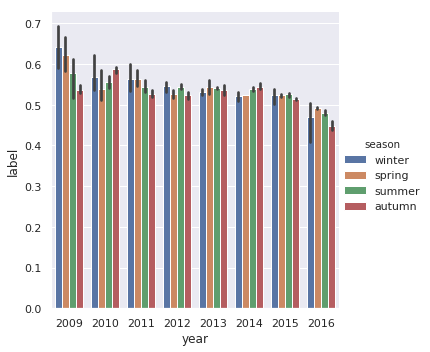

In [17]:
sns.factorplot(x='year', y='label', hue='season', data=seasonal_time_year, kind='bar')

**I see no trends in seasonal data**

In [56]:
train_df.created_utc = pd.to_datetime(train_df.created_utc)
train_df['hour_created'] = train_df.created_utc.dt.hour
train_df.head()

,label,comment,author,subreddit,score,ups,downs,date,created_utc,parent_comment,hour_created
0,0,NC and NH.,Trumpbart,politics,2,-1,-1,2016-10,2016-10-16 23:55:23,"Yeah, I get that argument. At this point, I'd ...",23
1,0,You do know west teams play against west teams...,Shbshb906,nba,-4,-1,-1,2016-11,2016-11-01 00:24:10,The blazers and Mavericks (The wests 5 and 6 s...,0
2,0,"They were underdogs earlier today, but since G...",Creepeth,nfl,3,3,0,2016-09,2016-09-22 21:45:37,They're favored to win.,21
3,0,"This meme isn't funny none of the ""new york ni...",icebrotha,BlackPeopleTwitter,-8,-1,-1,2016-10,2016-10-18 21:03:47,deadass don't kill my buzz,21
4,0,I could use one of those tools.,cush2push,MaddenUltimateTeam,6,-1,-1,2016-12,2016-12-30 17:00:13,Yep can confirm I saw the tool they use for th...,17


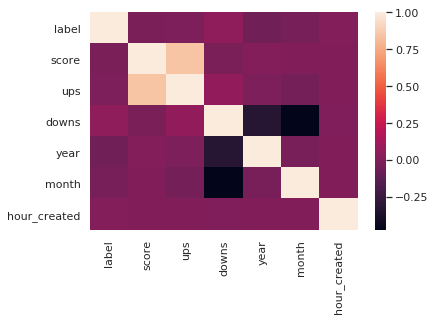

In [19]:
train_df.month = train_df.month.astype(int)
train_df.year = train_df.year.astype(int)
sns.heatmap(train_df.corr())

**It can be clearly seen, that the only numerical feature, with which label has correlation is amount of downvotes**

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


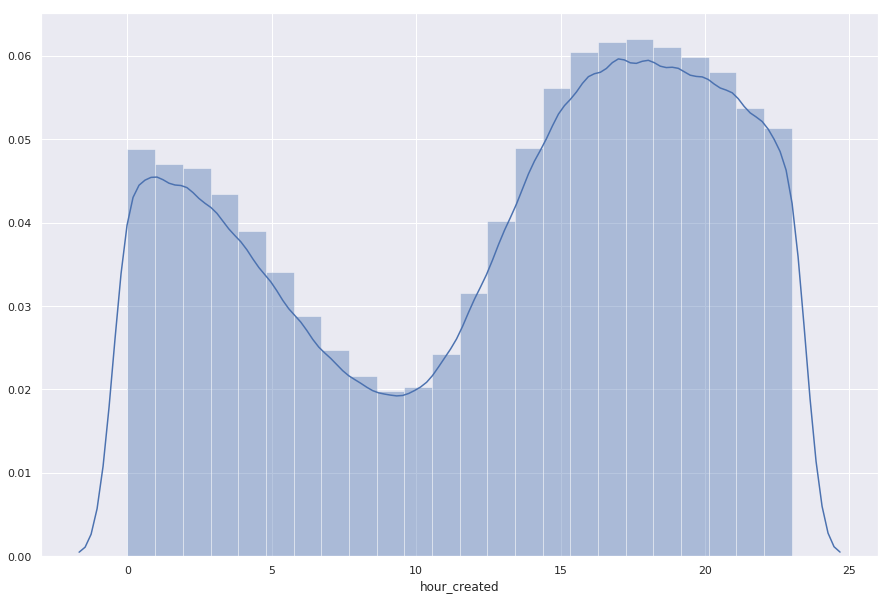

In [57]:
sns.distplot(train_df.loc[train_df['label'] == 1, 'hour_created'], bins=24)

**The distribution is quite weird, but we clearly can see the tendency for sarcasm post to appear after 11 am and 
before 0 am**

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


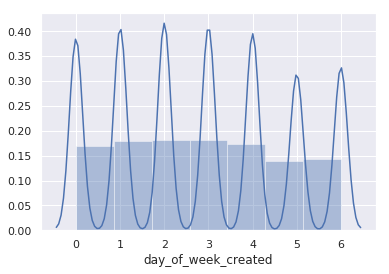

In [21]:
train_df['day_of_week_created'] = train_df.created_utc.dt.dayofweek
sns.distplot(train_df.loc[train_df['label'] == 1, 'day_of_week_created'], bins=7)

**The trend is monotone, except for the weekends, where the amount of sarcastic comments decreases. Maybe, this happens, because people are usually less exhaused on weekends**

In [22]:
len(train_df.subreddit.unique()) # there 14876 unique subreddits

14876

In [23]:
train_df.head()

,label,comment,author,subreddit,score,ups,downs,date,created_utc,parent_comment,year,month,hour_created,day_of_week_created
0,0,NC and NH.,Trumpbart,politics,2,-1,-1,2016-10,2016-10-16 23:55:23,"Yeah, I get that argument. At this point, I'd ...",2016,10,23,6
1,0,You do know west teams play against west teams...,Shbshb906,nba,-4,-1,-1,2016-11,2016-11-01 00:24:10,The blazers and Mavericks (The wests 5 and 6 s...,2016,11,0,1
2,0,"They were underdogs earlier today, but since G...",Creepeth,nfl,3,3,0,2016-09,2016-09-22 21:45:37,They're favored to win.,2016,9,21,3
3,0,"This meme isn't funny none of the ""new york ni...",icebrotha,BlackPeopleTwitter,-8,-1,-1,2016-10,2016-10-18 21:03:47,deadass don't kill my buzz,2016,10,21,1
4,0,I could use one of those tools.,cush2push,MaddenUltimateTeam,6,-1,-1,2016-12,2016-12-30 17:00:13,Yep can confirm I saw the tool they use for th...,2016,12,17,4


Now, let's have a look at some text features

In [58]:
vectorizer = TfidfVectorizer(ngram_range=(1, 2), max_features=50000, min_df=2)
vectorized_comments = vectorizer.fit_transform(train_df['comment'])
vectorized_comments.shape

(1010773, 50000)

Let's do the same to parent comments

In [76]:
X_train, y_train = train_df.loc[:,['hour_created']], train_df.loc[:,'label']

In [77]:
from sklearn.preprocessing import LabelEncoder

In [79]:
X_train.head()

,hour_created
0,23
1,0
2,21
3,21
4,17


In [80]:
from scipy.sparse import hstack

In [93]:
X_train, X_test, y_train, y_test = \
train_test_split(hstack([X_train, vectorized_comments]), y_train, random_state=17)

ValueError: blocks[0,:] has incompatible row dimensions. Got blocks[0,1].shape[0] == 1010773, expected 758079.

In [82]:
logit = LogisticRegression(random_state=17, n_jobs=-1, verbose=True, solver='lbfgs')
parameters = {'C' : np.logspace(-2, 2, 5)}

In [86]:
clf = GridSearchCV(logit, parameters, cv=5)
clf.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   13.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    9.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   10.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   13.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   11.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   17.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn', n_jobs=-1,
          penalty='l2', random_state=17, solver='lbfgs', tol=0.0001,
          verbose=True, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'C': array([1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [88]:
logit.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   19.9s finished


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn', n_jobs=-1,
          penalty='l2', random_state=17, solver='lbfgs', tol=0.0001,
          verbose=True, warm_start=False)

In [91]:
accuracy_score(y_test, clf.predict(X_test))

0.7054263259119726

In [90]:
accuracy_score(y_test, logit.predict(X_test))

0.7054263259119726

In [38]:
import eli5
eli5.show_weights(estimator=clf)

In [75]:
clf.best_params_

{'C': 1.0}